# Classification
We now consider some examples of supervised learning. We will use the scikit-learn library in Python to do this. [Scikit-Learn](http://scikit-learn.org/), aka sklearn, is one of the most popular and easiest to use machine learning libraries out there. Though it is somewhat limited in what it can do (it's not good for deep learning in particular), it's great for everyday machine learning. 

For our example, we will focus on classification using the two main techniques we've covered: logistic regression and KNN, and we'll also quickly mention a couple of the more state of the art techniques. To begin, we load the functions we'll need. When doing machine learning, you almost always need [numpy](http://www.numpy.org/) (Python's linear algebra library) and [matplotlib](https://matplotlib.org/) or some other library for plotting. From sklearn, we import the classes used for the models we'll be using, a function that automatically splits our dataset into a training set and a test set (to prevent overfitting), and a function that allows us to calculate our training accuracy (percent of correctly classified labels) automatically. We also set a random seed, which is good practice when working with random numbers (as we frequently do in machine learning) to ensure reproducibility of our results.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn import metrics
from sklearn.model_selection import train_test_split
np.random.seed(1)

Next, we load a function to generate the simulated data we'll be training on. If you're curious, the function generates 1000 data points using a 2D Gaussian mixture model with five centers per label.

In [2]:
def gen_data(size=1000, centers=5):
    M = [np.random.multivariate_normal(np.array([1,0]),.8*np.eye(2)) for i in range(centers)] +\
        [np.random.multivariate_normal(np.array([0,1]),.8*np.eye(2)) for i in range(centers)]
    
    X = np.zeros((size,2))
    y = np.zeros((size,))
    x1 = []
    x2 = []    
    for j in range(size):
        i = np.random.randint(2*centers)
        m = M[i]
        X[j,:] = np.random.multivariate_normal(np.array(m),.8*np.eye(2)/centers)
        if i<centers:
            y[j] = 0
            x1 += [X[j,:]]
        else:
            y[j] = 1
            x2 += [X[j,:]]
    x1 = np.array(x1).reshape(len(x1),2)
    x2 = np.array(x2).reshape(len(x2),2)
    return X,y,x1,x2

Next, we load a plotting routine. This will allow us to visualize the data and plot decision boundaries to see how well our model is doing.

In [3]:
def plot_model(model, X, y, x1, x2):
    xlim_left = np.min(X[:,0])
    xlim_right = np.max(X[:,0])
    ylim_left = np.min(X[:,1])
    ylim_right = np.max(X[:,1])
    xx, yy = np.mgrid[xlim_left-1:xlim_right+1:.01, ylim_left-1:ylim_right+1:.01]
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    f, ax = plt.subplots(figsize=(8, 8))
    
    if model is not None:
        yhat = model.predict(grid).reshape(xx.shape)
        ax.contour(xx, yy, yhat, levels=[.5])
    
    ax.scatter(x1[:,0],x1[:,1],marker='.',c='red',label='y=0')
    ax.scatter(x2[:,0],x2[:,1],marker='.',c='blue',label='y=1')
    
    ax.set(aspect="equal",
           #xlim=(-3, 3), ylim=(-3, 3),
           xlabel="$X_1$", ylabel="$X_2$")
    ax.legend(loc='upper right')

Last, we define a function to generate the scores we'll use to evaluate how well our models are doing.

In [4]:
def get_scores(model, X_train, y_train, X_test, y_test):
    yhat = model.predict(X_train)
    ypred = (yhat>.5)
    conf = metrics.confusion_matrix(y_train,ypred)
    acc = (conf[0,0]+conf[1,1])*1./(conf[0,0]+conf[0,1]+conf[1,0]+conf[1,1])
    print('Training Accuracy: '+str(acc*100.)+'%')

    yhat = model.predict(X_test)
    ypred = (yhat>.5)
    conf = metrics.confusion_matrix(y_test,ypred)
    acc = (conf[0,0]+conf[1,1])*1./(conf[0,0]+conf[0,1]+conf[1,0]+conf[1,1])
    print('Test Accuracy: '+str(acc*100.)+'%')

Now that we've got this out of the way we can proceed with the machine learning. First, we generate the data, saving inputs into a matrix `X` and the outputs into a vector `y`. Each row of `X` is a single example and each column is a feature. This is pretty much the standard format for storing data when doing machine learning, and almost every machine learning algorithm assumes your data is stored this way. We also store two more arrays `x1` and `x2` that separates the input data by label, just for plotting purposes.

Next, we separate the data into a training set and a test set using the `train_test_split` function. Remember this is to prevent overfitting. We want to train only on the training data `X_train` and `y_train`, and test our model only on the test data `X_test` and `y_test`. The `test_size=0.2` term means that we want 80% of our total data to go into the training set, and the remaining 20% into the test set. This is a fairly standard way to split your data. You always want most of your data going into your training set because models tend to train better when given more data. But you need to have enough test data to reliably evaluate your model, so you can't skimp there either.

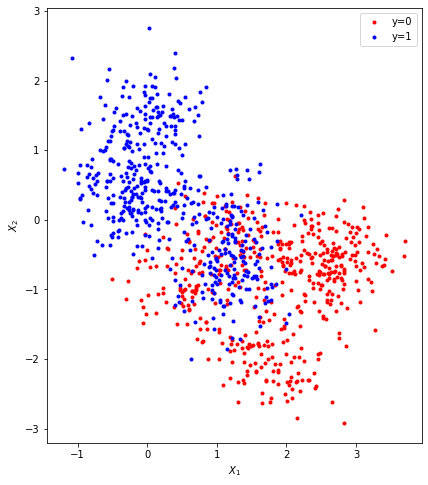

In [5]:
X,y,x1,x2 = gen_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
plot_model(None, X, y, x1, x2)

Since our data is set up for training we can now get to the modeling. First we use [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression). As mentioned in the background, LR classifies points $x$ by learning the optimal parameters $w,b$ to fit the _sigmoid_ function
$$ \hat y(x) = \frac{1}{1+e^{w^Tx+b}}.$$
Classification is then done by rounding $\hat y$ to the nearest integer (it's always between 0 and 1).

Note the Scikit-Learn APIs are object-oriented, so we first have to instantiate the model class, and then call the fit method for the actual training. After the fit method obtains the optimal weights, we call the predict method on both our training and test sets to get our optimal predictions $\hat y$, and then evaluate how well the model is doing.

Keep in mind our goal here is to find the best model. By "best model" we translate that as: find the model that gives the highest test set accuracy (defined below) on our dataset. This is often, but not always, the most reasonable technique for deciding which model is best to use at the end of the day. Note in real life model accuracy may need to be balanced against other things as well, such as latency (how long does the model take to run), interpretability (how easy is it to determine which features most determine the decision made by a model), or proprietary concerns (is the algorithm or software owned by a company you're competing with).

In classification, the simplest way to tell how well a model is doing is by measuring its test set [accuracy](https://en.wikipedia.org/wiki/Evaluation_of_binary_classifiers). Accuracy is simply the ratio of labels in the dataset that the model classified correctly.

Finally, we use the plot function we defined above to show our classification. What do you notice about the decision boundary in particular?

Training Accuracy: 79.625%
Test Accuracy: 76.0%


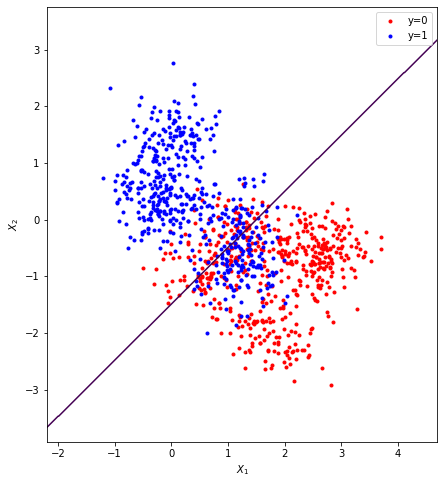

In [6]:
model = LogisticRegression()
model.fit(X_train, y_train)

get_scores(model, X_train, y_train, X_test, y_test)
plot_model(model, X, y, x1, x2)

Next, let's try using a [k-nearest neighbors](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) model instead. With classification, KNN calculates the mode of the $k$ nearest points and uses that to make a prediction, $$\hat y(x) = \text{mode}(y_1,\dots,y_k),$$ where $x_1,\dots,x_k$ are the $k$ closest values to $x$, having labels $y_1,\dots,y_k$. That is, KNN looks at the $k$ nearest neighbors to $x$ and takes a "majority vote" to determine what label $\hat y$ to assign to $x$.

Thanks to Scikit-Learn's simple API, the code is almost exactly the same as before, with the exception of the class we call. The `n_neighbors` parameter is the choice of $k$. What do you notice about the decision boundary now? Also, play around with different values of $k$ and see what happens to your training accuracy, test accuracy, and decision boundary.

Training Accuracy: 84.25%
Test Accuracy: 83.5%


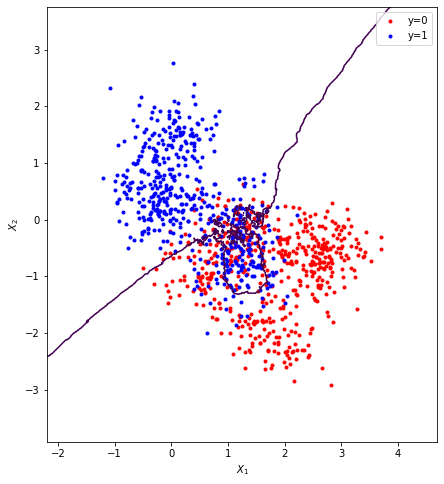

In [7]:
model = KNeighborsClassifier(n_neighbors=50)
model.fit(X_train, y_train)

get_scores(model, X_train, y_train, X_test, y_test)
plot_model(model, X, y, x1, x2)

We finish up by looking at a couple of the more state of the art classification algorithms: random forests and gradient boosting trees.

[Random forests](https://en.wikipedia.org/wiki/Random_forest) works by creating a whole bunch of decision trees, where each decision tree tries to find the best ways to split the data, and then averages the results together to make a prediction. This averaging is called _ensembling_ in machine learning. RFs are very popular algorithms to use when dealing with structured data in particular. They're also very interpretable, which is becoming more and more important in ML (if you're curious, look up the `tree-interpreter` library).

Training Accuracy: 86.875%
Test Accuracy: 84.5%


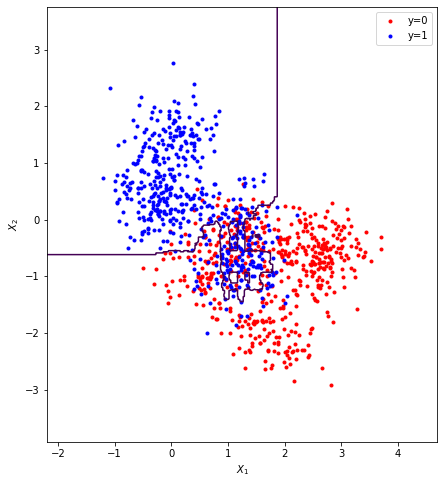

In [8]:
model = RandomForestClassifier(n_estimators=100,min_samples_leaf=13)
model.fit(X_train, y_train)

get_scores(model, X_train, y_train, X_test, y_test)
plot_model(model, X, y, x1, x2)

Last, we look at [gradient boosting machines](https://en.wikipedia.org/wiki/Gradient_boosting). While we use the sklearn `GradientBoostingClassifier` here, in practice there is a powerful library called XGBoost that you'd want to consider for this, as it's much faster to run (Note it can be a pain to install correctly due to its dependence on C++. I tried to download and run it here but kept running into issues.). 

GBMs are in many ways about as fancy as supervised ML gets when not dealing with neural networks. GBMs also work by creating decision trees, but instead of ensembling the trees it does _boosting_ on them. Boosting means that it takes the output of one tree, calculates its residual error $y-\hat y$, then feeds that into the next tree and uses that tree to try to predict that error. It does this over and over again.

Training Accuracy: 89.625%
Test Accuracy: 83.0%


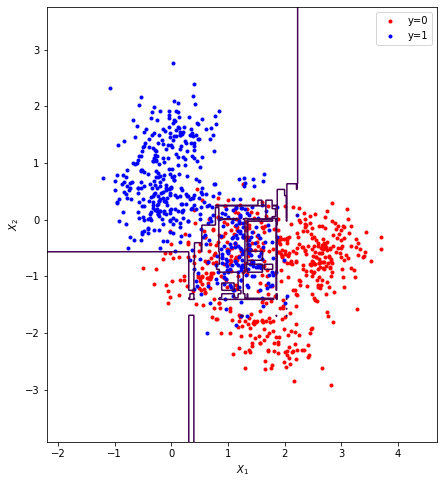

In [9]:
model = GradientBoostingClassifier(n_estimators=55)
model.fit(X_train,y_train)

get_scores(model, X_train, y_train, X_test, y_test)
plot_model(model, X, y, x1, x2)